In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

np.random.seed(42)

In [2]:
df = pd.read_csv('dataset.csv')
genres = df.iloc[:, -1]
le = LabelEncoder()
machinegenre = le.fit_transform(genres)
ss = StandardScaler()
X_standard = ss.fit_transform(np.array(df.iloc[:, :-1], dtype = float))
X = X_standard
y = machinegenre
name = ""

In [3]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [5]:
# Logistic Regression

In [6]:
params = {
    "cls__penalty": ["l1"],
    "cls__solver": ['liblinear'],
    "cls__C": [0.5, 1.0, 2.0, 5.0],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1.0, 2.0, 5.0], 'cls__max_iter': [500],
                         'cls__penalty': ['l1'], 'cls__solver': ['liblinear']},
             scoring='accuracy')

In [7]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7427
best score on test set (accuracy) = 0.7360


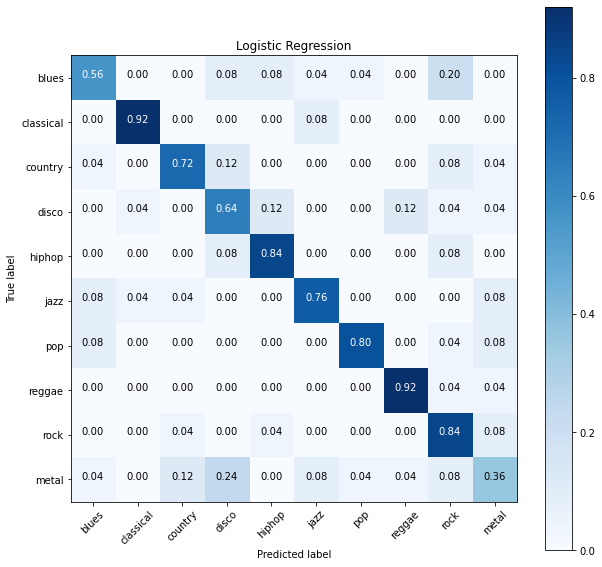

In [8]:
cm = confusion_matrix(y_test, preds)
classes = ['blues','classical','country','disco','hiphop','jazz','pop','reggae','rock','metal']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True, title='Logistic Regression')

In [9]:
# ElasticNet

In [10]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SGDClassifier())]),
             n_jobs=6,
             param_grid={'cls__l1_ratio': [0.15, 0.25, 0.5, 0.75],
                         'cls__loss': ['log'], 'cls__penalty': ['elasticnet']},
             scoring='accuracy')

In [11]:
preds = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.6813
best score on test set (accuracy) = 0.6840


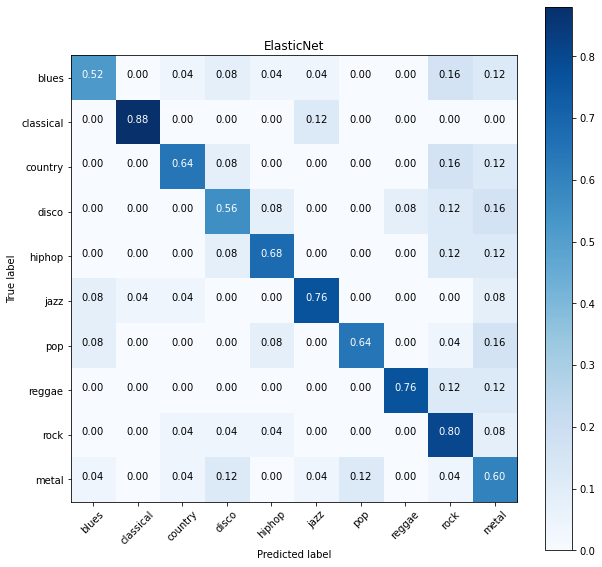

In [12]:
cm = confusion_matrix(y_test, preds)
classes = ['blues','classical','country','disco','hiphop','jazz','pop','reggae','rock','metal']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True, title='ElasticNet')

In [13]:
# Decision Tree

In [14]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [15]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5227
best score on test set (accuracy) = 0.5600


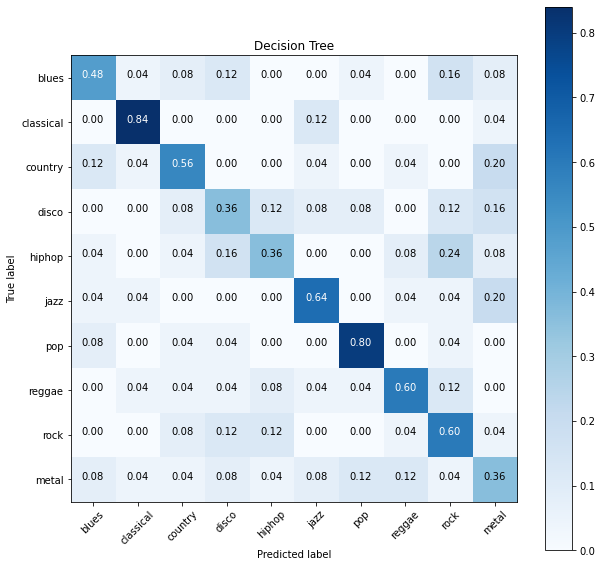

In [16]:
cm = confusion_matrix(y_test, preds)
classes = ['blues','classical','country','disco','hiphop','jazz','pop','reggae','rock','metal']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True, title='Decision Tree')

In [17]:
# Random Forest

In [ ]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

In [ ]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

In [ ]:
cm = confusion_matrix(y_test, preds)
classes = ['blues','classical','country','disco','hiphop','jazz','pop','reggae','rock','metal']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True, title='Random Forest')

In [ ]:
# SVM

In [ ]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

In [ ]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

In [ ]:
cm = confusion_matrix(y_test, preds)
name = 'ElasticNet'
classes = ['blues','classical','country','disco','hiphop','jazz','pop','reggae','rock','metal']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True, title='SVM')

In [ ]:
# K-Means Clustering

In [ ]:
# KNN

In [ ]:
# CNN